In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
acquisition_fm3_path = {
    "pre-tvac": "data/20240607_hermes_fm3_177Lu_900s_pretvac_LV0d5.fits",
    "post-tvac": "data/20240731_hermes_fm3_177Lu_900s_posttvac_LV0d5.fits"
}

lu176_201 = 201.83
lu176_306 = 306.78
sources = [lu176_201, lu176_306]

# Payload temperatures

Both the acquisitions (before and after TVAC) were acquired at high temperatures (28C and 30C BEE temperatures, respectively).
We have calibrations up to 20°C, which means we expect inaccuracies in the energy estimates. 

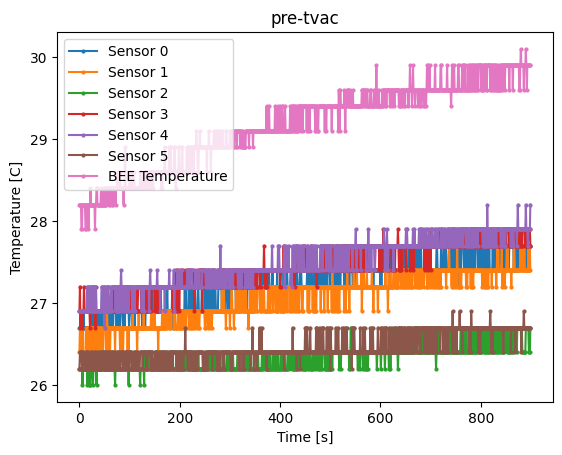

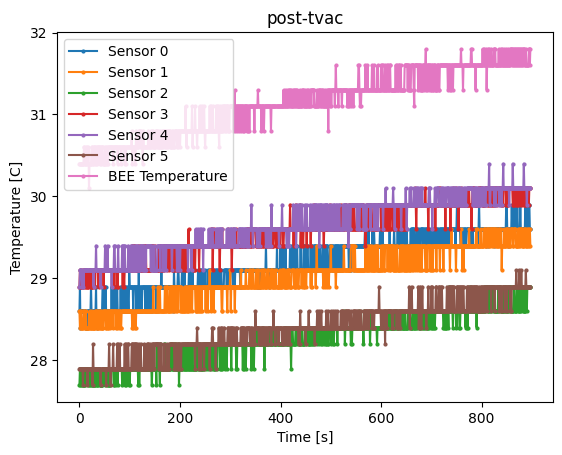

In [3]:
from astropy.io import fits

for label, filepath in acquisition_fm3_path.items():
    with fits.open(filepath) as f:
        hk_data = f[1].data
    
    temp_array = np.hstack((hk_data["FEETEMPP"], np.expand_dims(hk_data["BEETEMPP"], axis=1)))
    temp_df = pd.DataFrame(temp_array, columns=[f"Sensor {i}" for i in range(6)] + ["BEE Temperature"])
    temp_df.plot(ylabel="Temperature [C]", xlabel="Time [s]", marker="o", title=f"{label}", kind="line", ms=2)
    plt.show()


# Preparing calibrations

In [29]:
from functools import partial

from source.calibrate import ImportedCalibration
from source.io import read_sdd_calibration_report, read_lightout_report, pandas_from_lv0d5
from source.eventlist import preprocess

class FakeConsole:
    def __init__(self):
        return

    def log(self, msg):
        pass

configuration = {"xbinning": 10, "sbinning": 10}
model="fm3"

sdd_calibration = read_sdd_calibration_report(Path("calibs/standard/report_cal.xlsx"))
slo_calibration = read_lightout_report(Path("calibs/standard/report_slo.xlsx"))

sdd_posttvac_calib = read_sdd_calibration_report(Path("calibs/posttvac/report_cal.xlsx"))
slo_posttvac_calib = read_lightout_report(Path("calibs/posttvac/report_slo.xlsx"))

sdd_pretvac_calib = read_sdd_calibration_report(Path("calibs/pretvac/report_cal.xlsx"))
slo_pretvac_calib = read_lightout_report(Path("calibs/pretvac/report_slo.xlsx"))

def _calibrate_data(datafile, model, sdd_calibration, slo_calibration, configuration):
    data = pandas_from_lv0d5(datafile)
    data, waste = preprocess(
        data,
        model=model,
        filter_spurious=True,
        filter_retrigger=20*10**-6,
    )
    calibration = ImportedCalibration(
        model=model,
        configuration=configuration,
        sdd_calibration=sdd_calibration,
        lightoutput=slo_calibration,
        console=FakeConsole(),
    )
    return calibration(data), calibration


calibrate_standard = partial(_calibrate_data, model=model, sdd_calibration=sdd_calibration, slo_calibration=slo_calibration, configuration=configuration)
calibrate_posttvac = partial(_calibrate_data, model=model, sdd_calibration=sdd_posttvac_calib, slo_calibration=slo_posttvac_calib, configuration=configuration)
calibrate_pretvac = partial(_calibrate_data, model=model, sdd_calibration=sdd_pretvac_calib, slo_calibration=slo_pretvac_calib, configuration=configuration)

In [30]:
dataframes = {label: calibrate_standard(datafile) for label, datafile in acquisition_fm3_path.items()}

In [31]:
dfs_posttv = {label: calibrate_posttvac(datafile) for label, datafile in acquisition_fm3_path.items()}

In [32]:
dfs_pretv = {label: calibrate_pretvac(datafile) for label, datafile in acquisition_fm3_path.items()}

# Maps

From counts map we can see that all channels which were working prior to TVAC are still working post TVAC.

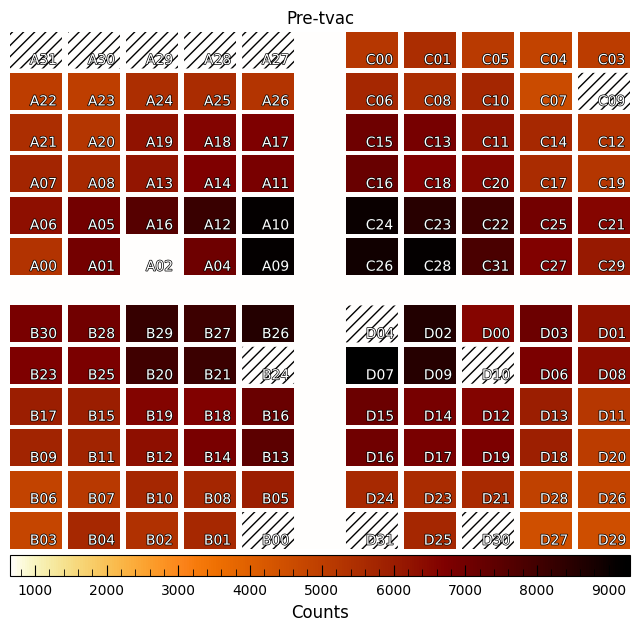

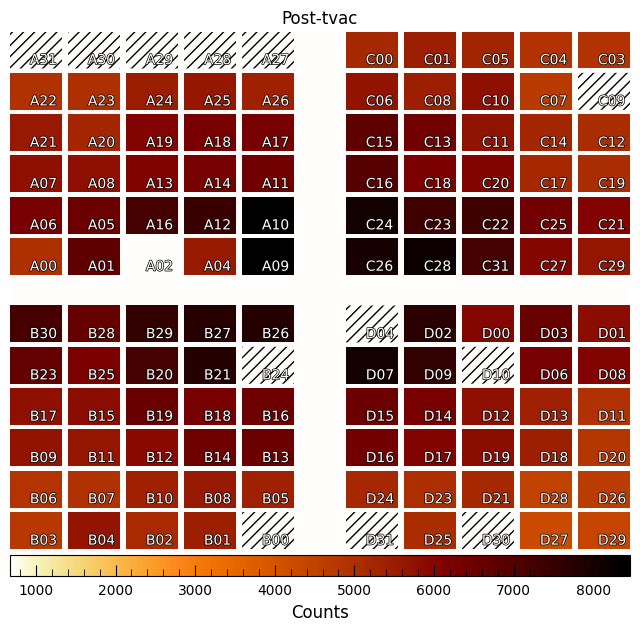

In [33]:
from source.io import pandas_from_lv0d5
from source.plot import mapcounts
from source.calibrate import perchannel_counts
from source.detectors import Detector

dmap = Detector("fm3").map

df = pandas_from_lv0d5(acquisition_fm3_path["pre-tvac"])
fig, ax = mapcounts(perchannel_counts(df, {quad: [i for i in range(32)] for quad in "ABCD"}), dmap, title="Pre-tvac")

df = pandas_from_lv0d5(acquisition_fm3_path["post-tvac"])
fig, ax = mapcounts(perchannel_counts(df, {quad: [i for i in range(32)] for quad in "ABCD"}), dmap, title="Post-tvac")


# Spectra

In [34]:
def histogram(data):
    bins = np.arange(50, 1500, .5)
    midpoints = (bins[:-1] + bins[1:]) / 2
    return np.histogram(data["ENERGY"], bins=bins)[0], midpoints

In [35]:
from astropy.io import fits
from scipy.interpolate import interp1d

with fits.open("calibs/hermes_mixedsplice.fits") as content:
    corr_factor = content[1].data
    f1 = interp1d(corr_factor["ENERGY"], corr_factor["CORRFACTOR"])

### Standard calibration

First we try to calibrate both acquisitions with the standard 20°C calibration.

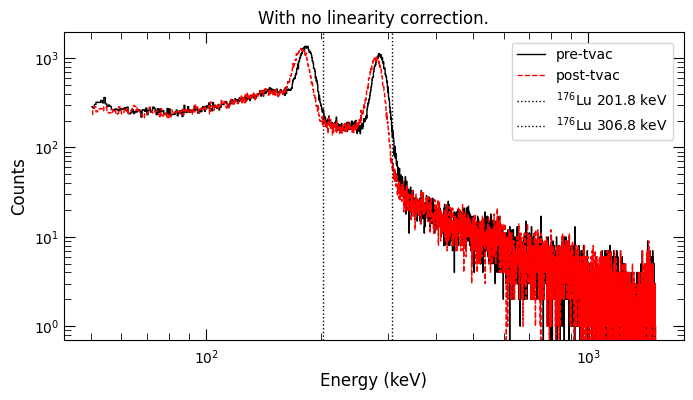

In [36]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for label, (data, calibration) in dataframes.items():
    counts, midpoints = histogram(data) 
    ax.step(midpoints, counts, where="mid", label=label)
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("With no linearity correction.")
plt.show()

A discrepancy is apparent. We attempt correcting for non-linearity. While we get some improvements, we are still off. This discrepancy is purely due to the difference between the acquisition temperatures and the temperature of the acquisition from which we obtained the standard calibration.

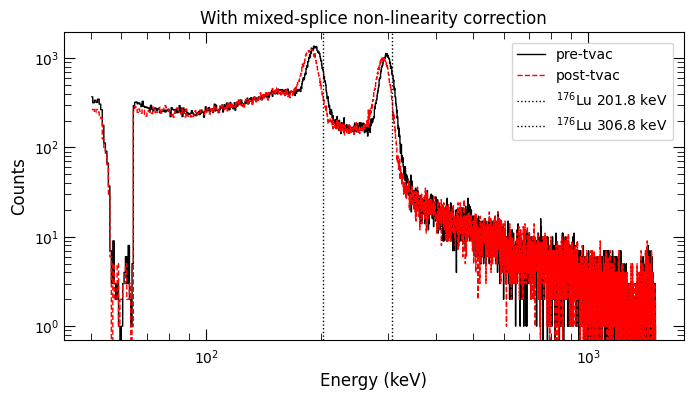

In [37]:
def get_mask(df):
    return (df["ENERGY"] > 10) & (df["EVTYPE"] == "S") & (df["ENERGY"] < 1999.90)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for label, (data, calibration) in dataframes.items():
    data = {"ENERGY": data[get_mask(data)]["ENERGY"] / f1(data[get_mask(data)]["ENERGY"])}
    counts, midpoints = histogram(data)
    ax.step(midpoints, counts, where="mid", label=f"{label}")
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("With mixed-splice non-linearity correction")
plt.show()

### PostTVAC calibration

To improve on this, we made a new calibration using the X data obtained with standard calibs, and the lutetium line for calibrating the scintillator, both for the acquisition before and after the TVAC tests. Since we are using the light-outputs computed directly from the lutetium lines, there is no need to correct for non-linearity

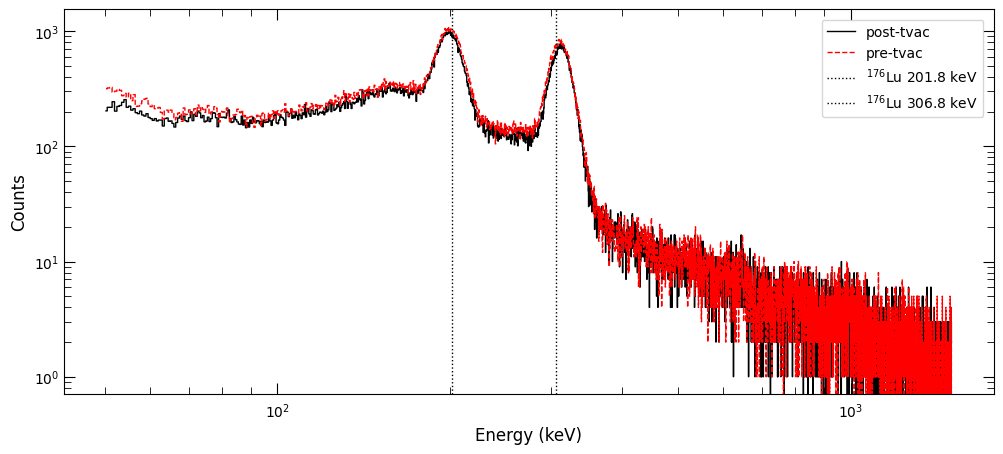

In [40]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
label = "post-tvac"
data, calibration = dfs_posttv[label]
counts, midpoints = histogram(data) 
ax.step(midpoints, counts, where="mid", label=label)
label = "pre-tvac"
data, calibration = dfs_pretv[label]
counts, midpoints = histogram(data) 
ax.step(midpoints, counts, where="mid", label=label)
for source in sources:
    plt.axvline(source, label=f"$^{{176}}$Lu {source:.1f} keV", linestyle="dotted")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.show()

# Changes in light output

However, we can  isolate the effect of temperature on the scintillator calibration, comparing the standard calibration light output with the ones computed from the post-tvac acquisition. As shown in the figure, the light output values differs on average by a fixed offset. This offset would be zero if the acquisition temperatures were the same. 

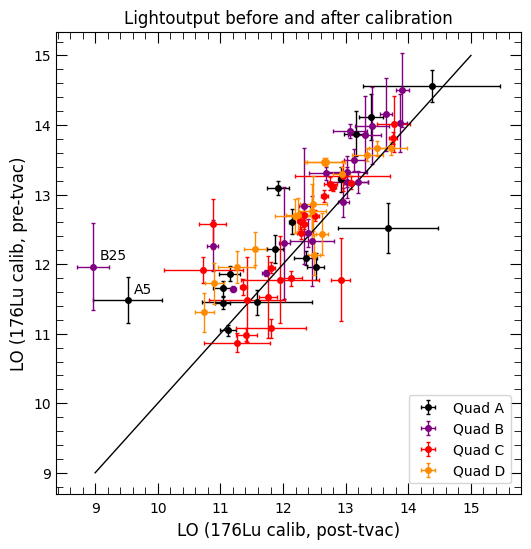

In [57]:
plt.subplots(1, 1, figsize=(6,6))
for quad, color in zip("ABCD",["black", "purple", "red", "darkorange"]):
    indeces = slo_pretvac_calib[quad]["light_out"].index.intersection(slo_posttvac_calib[quad]["light_out"].index)
    plt.errorbar(
        slo_posttvac_calib[quad]["light_out"][indeces], 
        slo_pretvac_calib[quad]["light_out"][indeces], 
        xerr=slo_posttvac_calib[quad]["light_out_err"][indeces], 
        yerr=slo_pretvac_calib[quad]["light_out_err"][indeces], 
        c=color, capsize=1.1,
        fmt = "o", label=f"Quad {quad}") 
    for ch in indeces:
        x = slo_posttvac_calib[quad]["light_out"].loc[ch]
        y = slo_pretvac_calib[quad]["light_out"].loc[ch]
        if x < y * .85:
            epsilon = .1
            plt.text(x + epsilon, y + epsilon, f"{quad}{ch}")
xs = np.linspace(9, 15, 100)
plt.plot(xs, xs)
plt.xlabel("LO (176Lu calib, post-tvac)")
plt.ylabel("LO (176Lu calib, pre-tvac)")
plt.title("Lightoutput before and after calibration")
plt.legend(loc = 4)
plt.show()
